In [56]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, accuracy_score
    , confusion_matrix, ConfusionMatrixDisplay
)

import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [59]:
# If not installed already, install the spaCy large model and the 
# !python -m spacy download en_core_web_trf 
# !python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 2.5 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for spacy-curated-transformers<1.0.0,>=0.2.2 from https://files.pythonhosted.org/packages/42/d8/f053d43125ae4ad14f3e2a12a475a656128233f1f40a272c6e09a05c73e8/spacy_curated_transformers-0.3.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for curated-transformers<0.2.0,>=0.1.0 from https://files.pythonhosted.org/packages/d6/67/3b72b3fdfcadab61bc8f59c17e63770e526ffabd583ed32f174a7c01af85/curated_transformers-0.1.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for curated-tokenizers<0.1.0,>=0.0.9 from https://files.pythonhosted.org/packages/1f/f2/e4fa27a078ca6d7db87f82124695ce8822104285d4f8b3ec9900ab18c2df/curated_tokenizers-0.0.9-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.9/237.9 kB 952.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.6/733.6 kB 4.6 MB/s 

In [60]:
# Load SpaCy model

nlp = spacy.load("en_core_web_lg")

In [61]:
# Custom tokenizer using SpaCy
def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

In [62]:
# Load the dataset from Hugging Face:
df = pd.read_parquet("hf://datasets/tdavidson/hate_speech_offensive/data/train-00000-of-00001.parquet")

df.shape
df.head()
df.info()

(24783, 6)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [5]:
df['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [63]:
# Encode labels:
# 0: 'hate-speech', 1: 'offensive-language' or 2: 'neither'

df['label_actual'] = df['class'].map({0: 'hate-speech', 1: 'offensive-language', 2: 'neither' })

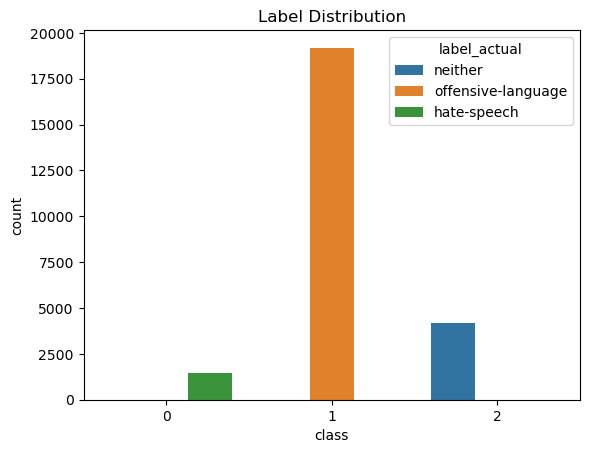

In [64]:
# Visualize label distribution
sns.countplot(
    x='class', data=df, hue='label_actual'
)
plt.title("Label Distribution")
plt.show();

In [8]:
df.head(1)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,label_actual
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither


In [65]:
X = df['tweet']
y = df['class']

X.shape, y.shape

((24783,), (24783,))

In [66]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
    , random_state=27, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19826,), (4957,), (19826,), (4957,))

In [68]:
# Vectorize text data using TfidfVectorizer (* with spaCy_tokenizer;)
tfidf = TfidfVectorizer(
    tokenizer=spacy_tokenizer, lowercase=True
#     , stop_words='english' # adding in the english stopwords w/ spaCy tokenizer; might break the model,,,
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [69]:
X_train_tfidf.shape, X_test_tfidf.shape

X_train_tfidf

((19826, 31658), (4957, 31658))

<19826x31658 sparse matrix of type '<class 'numpy.float64'>'
	with 159998 stored elements in Compressed Sparse Row format>

In [109]:
# Initialize models for comparison
# NOTE: This is a MULTICLASS problem-set; (e.g. it does not have a binary classification, but rather, there are three possible lables; while MultinomialNB is already set to deal with this, the others need to have various params added {all of which have a key of 'ovr;'})
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(
        max_iter=1000, random_state=27, multi_class='ovr'
    ),
    'SVC': SVC(random_state=27, decision_function_shape='ovr'),
    'LinearSVC': LinearSVC(
        max_iter=1000, random_state=27, multi_class='ovr'
    )
}

In [110]:
# Evaluate models
for name, model in models.items():
    
    model.fit(X_train_tfidf, y_train)
    
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{name} Accuracy: {accuracy:.4f}")

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


MultinomialNB Accuracy: 0.7912


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,27
,solver,'lbfgs'
,max_iter,1000
,multi_class,'ovr'


LogisticRegression Accuracy: 0.8848


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


SVC Accuracy: 0.8961


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,27


LinearSVC Accuracy: 0.8919


In [ ]:
# Note ~ while SVC clearly has a "high accuracy", subsequent GridSearchCV showed that this model just classified EVERYTHING as '1'... likely given the massive imbalance in labels in training data; this is obviously not ideal; (The hyperparams cell for SVC has been shifted to the end of the notebook, for posterity. Its confusion matrix gave '0's for everything except classification '1';)

In [112]:
# Since SVC failed us miserably (see above dev comments), I dont have high hopes for Linear SVC; That said, LogReg gave us the next higest accuracy (and has a 'multi_class' option) - hence let's use LogisticRegression as our 'base model'

base_model = LogisticRegression()

In [119]:

param_grid = {
    'C': [0.01, 0.1, 1, 10]                   # Regularization strength
    , 'penalty': ['l2']                       # L1/L2 penalty (L2 most common with tfidf/BOW)
    , 'solver': ['lbfgs', 'saga']             # Solvers that support multiclass
    , 'multi_class': ['multinomial', 'ovr']   # Explicit multi-class strategies
    , 'max_iter': [1000]
}

grid_search = GridSearchCV(
    estimator=base_model
    , param_grid=param_grid
    , cv=5
    , scoring='accuracy'
    , n_jobs=-1
)

In [120]:
# Fit that ish!

grid_search.fit(X_train_tfidf, y_train)

,estimator,LogisticRegression()
,param_grid,"{'C': [0.01, 0.1, ...], 'max_iter': [1000], 'multi_class': ['multinomial', 'ovr'], 'penalty': ['l2'], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [121]:
# Print best hyperparameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.8989204073209928


In [122]:
# Evaluate best model on test data
best_model = grid_search.best_estimator_

# Now FIT the best_model (MUST DO BEFORE PREDICTING!!! {otherwise, you essentially reset the model! :o })
best_model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [123]:
y_test_pred = best_model.predict(X_test_tfidf)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.8910631430300585


array([[  85,  174,   27],
       [  89, 3643,  106],
       [   7,  137,  689]])

              precision    recall  f1-score   support

           0       0.47      0.30      0.36       286
           1       0.92      0.95      0.94      3838
           2       0.84      0.83      0.83       833

    accuracy                           0.89      4957
   macro avg       0.74      0.69      0.71      4957
weighted avg       0.88      0.89      0.88      4957



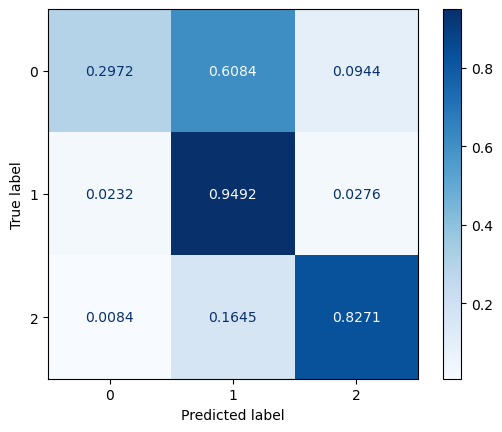

In [126]:
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test_tfidf, y_test, normalize='true'
    , cmap='Blues', values_format='.4f'
);

In [127]:
# Build a pipeline for testing on sample strings
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=spacy_tokenizer
        , lowercase=True
        , stop_words='english'
    ))
    , ('model', best_model)
])

In [128]:
# HAVE TO FIT THE PIPES!!!
# Since the model is already trained, can fit directly to X, y;

pipeline.fit(X, y)

,steps,"[('tfidf', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function spa...t 0x17778b920>


In [129]:
df.head(1)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,label_actual
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither


In [130]:
# Test pipeline on sample strings
sample_strings = [
    "You suck and I hate your stupid face!",
    "HFuckity fuck fucker fuckeroni",
    "Yo my dude foshizzlecoin is off the sheezy mothafucka",
    "Bitcoin is going to the moooooooon!",
    "Enlarge your portfolio 1000% with my proven investment secrets!",
    "@bizzle, whassup muh thugg",
    "This airline sucks!",
    "The thugg-lyfe chose ME"
]

In [131]:
predictions = pipeline.predict(sample_strings)

# Display predictions mapping
label_mapping = {0: 'hate-speech', 1: 'offensive-language', 2: 'neither'}

for text, label in zip(sample_strings, predictions):
    # Use the label to get the corresponding prediction
    prediction_text = label_mapping.get(label, 'unknown')
    print(f"Message: {text} -> Prediction: {prediction_text}\n")

Message: You suck and I hate your stupid face! -> Prediction: hate-speech

Message: HFuckity fuck fucker fuckeroni -> Prediction: offensive-language

Message: Yo my dude foshizzlecoin is off the sheezy mothafucka -> Prediction: offensive-language

Message: Bitcoin is going to the moooooooon! -> Prediction: offensive-language

Message: Enlarge your portfolio 1000% with my proven investment secrets! -> Prediction: neither

Message: @bizzle, whassup muh thugg -> Prediction: offensive-language

Message: This airline sucks! -> Prediction: offensive-language

Message: The thugg-lyfe chose ME -> Prediction: neither



In [132]:
X_test_tfidf.shape

(4957, 31658)

In [133]:
base_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [134]:
best_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [98]:
# np.logspace(-3, 2, 11).tolist()

In [99]:
# Define the parameter grid for GridSearchCV (using our 'base_model' above), with algo-specific hyperparams!

# Params for 'SVC()':

# param_grid = {
#     'C': np.logspace(-3, 2, 11)
#     , 'kernel': ['rbf'] # ['linear', 'rbf', 'poly'] - all are available but rbf is usually way to go;
#     , 'gamma': ['auto'] # ['scale', 'auto']
#     , 'decision_function_shape': ['ovr', 'ovo'] # Need this for multiclass!!!
#   #  , 'degree': [2, 3, 4]  # Only relevant for 'poly' kernel
# }

# # Initialize the GridSearchCV object
# grid_search = GridSearchCV(
#     estimator=base_model
#     , param_grid=param_grid
#     , scoring='accuracy'
#     , cv=5
#     , n_jobs=-1 # Runs on all cpu's
# )